In [1]:
import pandas as pd 
import numpy as np
from skimage import io, color, filters, feature
import matplotlib.pyplot as plt

In [2]:
import seaborn as sns
from sklearn.model_selection import train_test_split

In [3]:
df=pd.read_csv('data/age_gender.csv')

In [4]:
df.head()

,age,ethnicity,gender,img_name,pixels
0,1,2,0,20161219203650636.jpg.chip.jpg,129 128 128 126 127 130 133 135 139 142 145 14...
1,1,2,0,20161219222752047.jpg.chip.jpg,164 74 111 168 169 171 175 182 184 188 193 199...
2,1,2,0,20161219222832191.jpg.chip.jpg,67 70 71 70 69 67 70 79 90 103 116 132 145 155...
3,1,2,0,20161220144911423.jpg.chip.jpg,193 197 198 200 199 200 202 203 204 205 208 21...
4,1,2,0,20161220144914327.jpg.chip.jpg,202 205 209 210 209 209 210 211 212 214 218 21...


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23705 entries, 0 to 23704
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        23705 non-null  int64 
 1   ethnicity  23705 non-null  int64 
 2   gender     23705 non-null  int64 
 3   img_name   23705 non-null  object
 4   pixels     23705 non-null  object
dtypes: int64(3), object(2)
memory usage: 926.1+ KB


In [6]:
type(df['pixels'][0])

str

In [7]:
df['pixels'][0][0:10]

'129 128 12'

In [8]:
df['pixels']=df['pixels'].apply(lambda x:  np.array(x.split(), dtype="float32"))

In [9]:
X = np.array(df['pixels'].tolist())

## Converting pixels from 1D to 3D
X = X.reshape(X.shape[0],48,48)

In [10]:
X.shape

(23705, 48, 48)

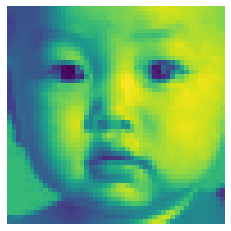

In [11]:
plt.imshow(X[2].reshape(48,48))
plt.axis('off')
plt.show()

__Ethnicity is an integer from 0 to 4, denoting White, Black, Asian, Indian, and Others (like Hispanic, Latino, Middle Eastern).__

In [12]:
df['gender_str']=df['gender'].map({1:'Female',0:'Male'})
df['ethnicity_str']=df['ethnicity'].map({0:'White',1:'Black', 2: 'Asian', 3: 'Indian', 4: 'Others'})

In [13]:
np.random.randint(0, len(X), 1)[0]

18230

In [14]:
np.array(df['age'])

array([ 1,  1,  1, ..., 99, 99, 99])

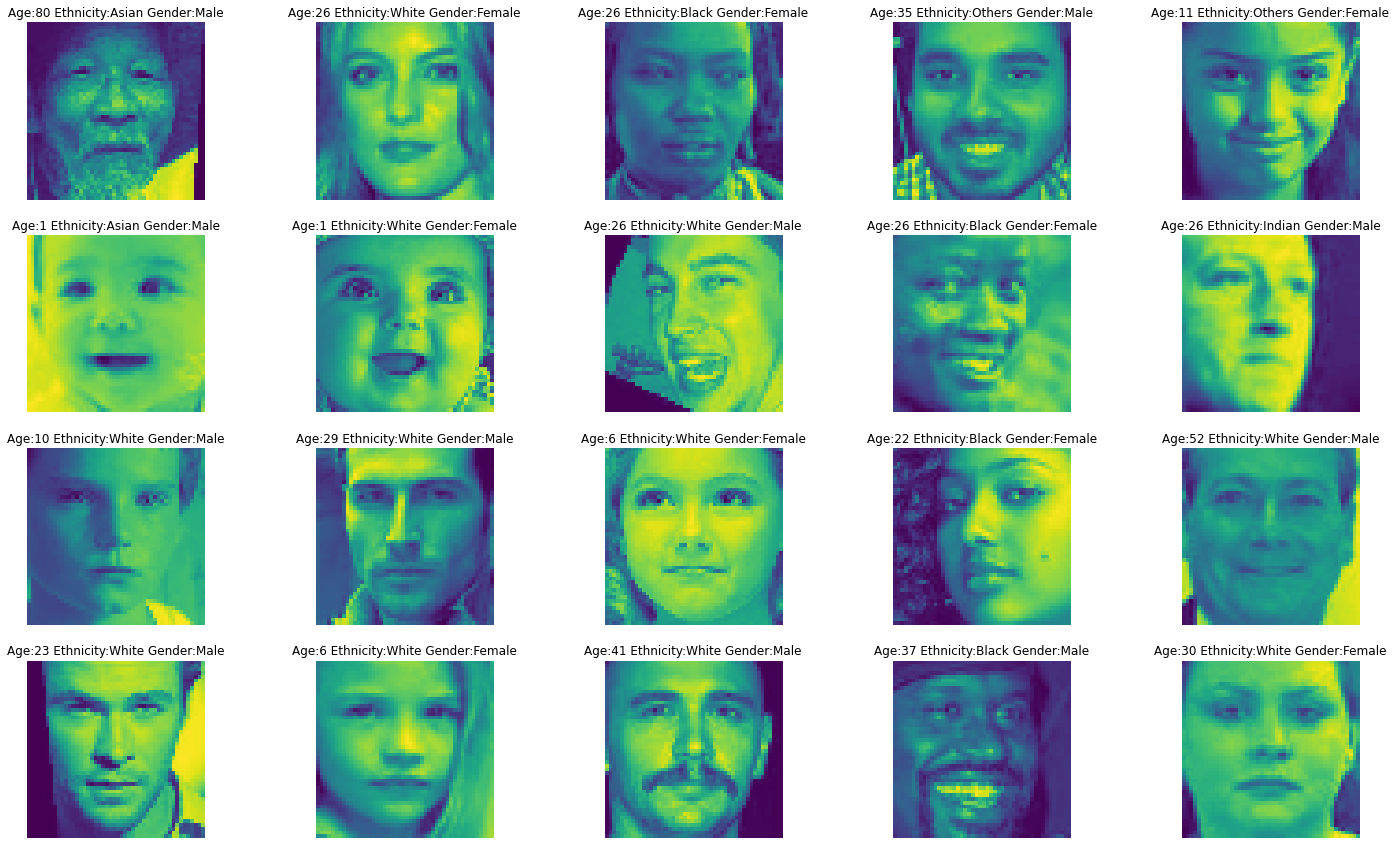

In [15]:
fig, axes = plt.subplots(4,5, figsize=(25,15))
# rand_number=np.random.randint(0, len(X), 20)
for ax in axes.flat:
    i=np.random.randint(0, len(X), 1)
    ax.imshow(X[i][0])
    ax.set_title(
 "Age:"+str(np.array(df['age'])[i][0])+" Ethnicity:"+str(np.array(df['ethnicity_str'])[i][0])+" Gender:"+str(np.array(df['gender_str'])[i][0])    )
    ax.axis('off')
plt.show()

In [16]:
df['age'].value_counts()

26     2197
1      1123
28      918
35      880
24      859
       ... 
115       3
101       2
91        2
103       1
111       1
Name: age, Length: 104, dtype: int64

# EDA

## __Age__

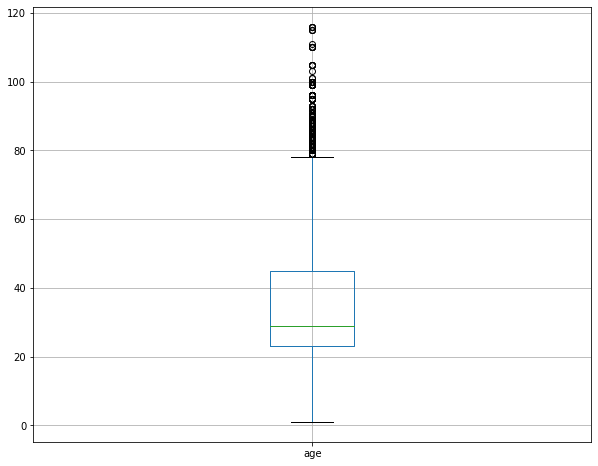

In [17]:
df[['age']].boxplot(figsize=(10,8));

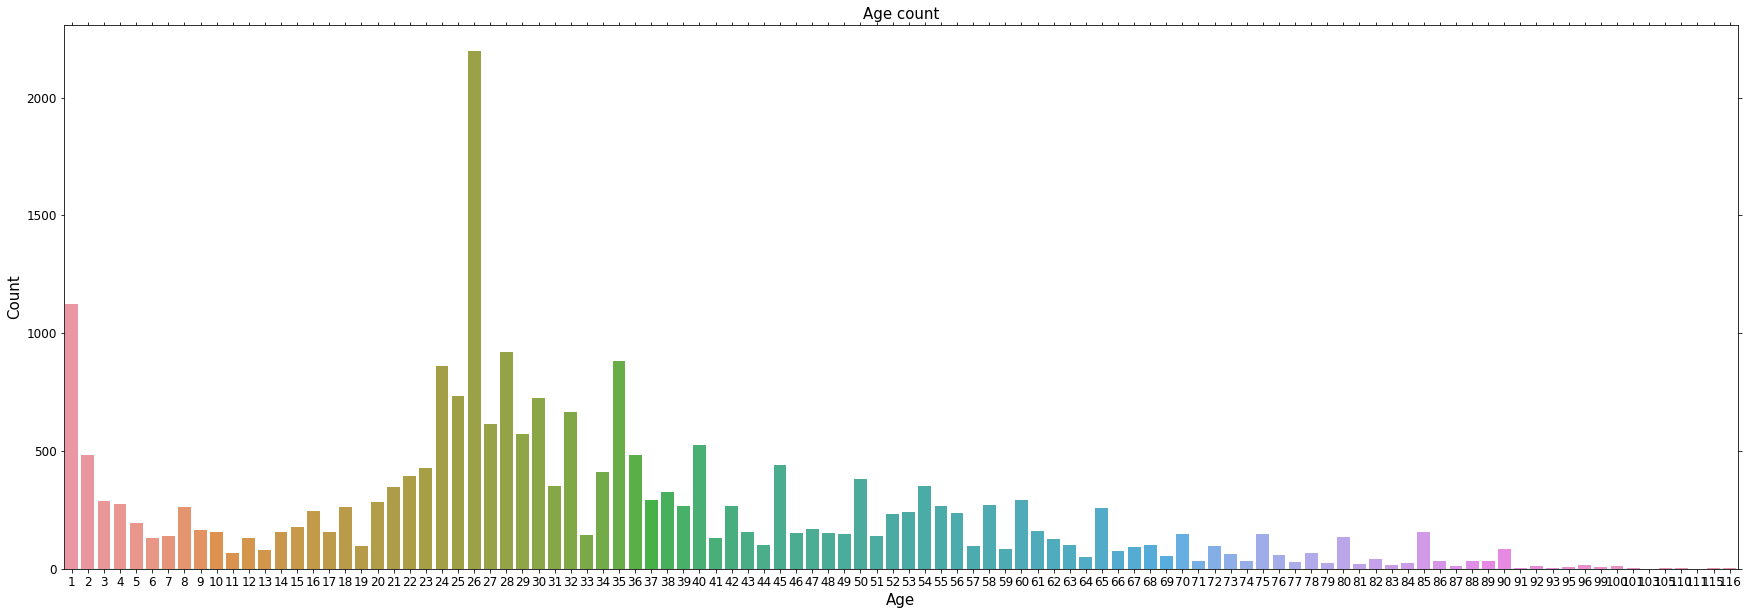

In [18]:
plt.figure(figsize=(30,10))
ax=sns.countplot(df['age'])
ax.set_title("Age count", size=15)
ax.set_xlabel("Age", size=15)
ax.set_ylabel("Count", size=15)
ax.tick_params(labelsize=12, reset= True)

## __Gender__

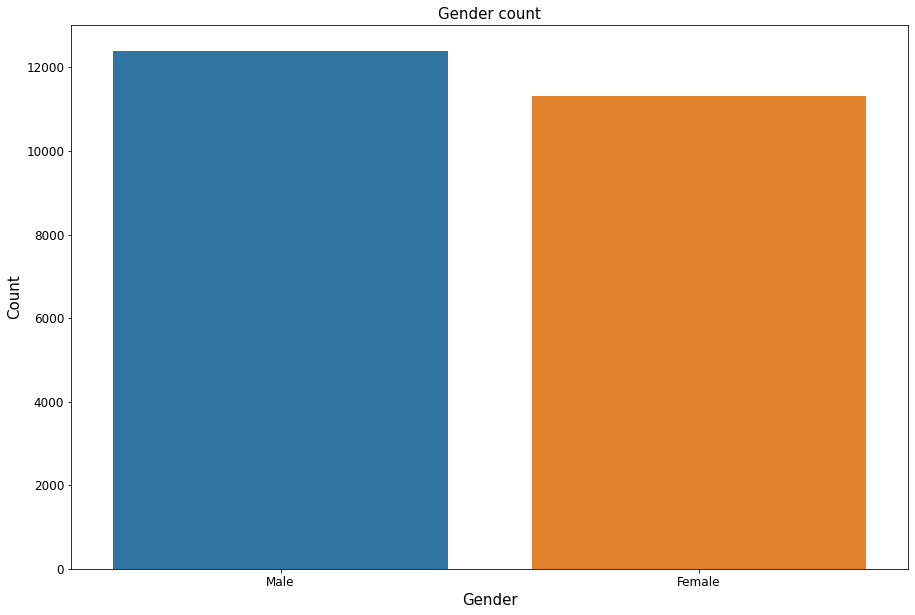

In [19]:
plt.figure(figsize=(15,10))
ax=sns.countplot(df['gender_str'])
ax.set_title("Gender count", size=15)
ax.set_xlabel("Gender", size=15)
ax.set_ylabel("Count", size=15)
ax.tick_params(labelsize=12);

## __Ethnicity__

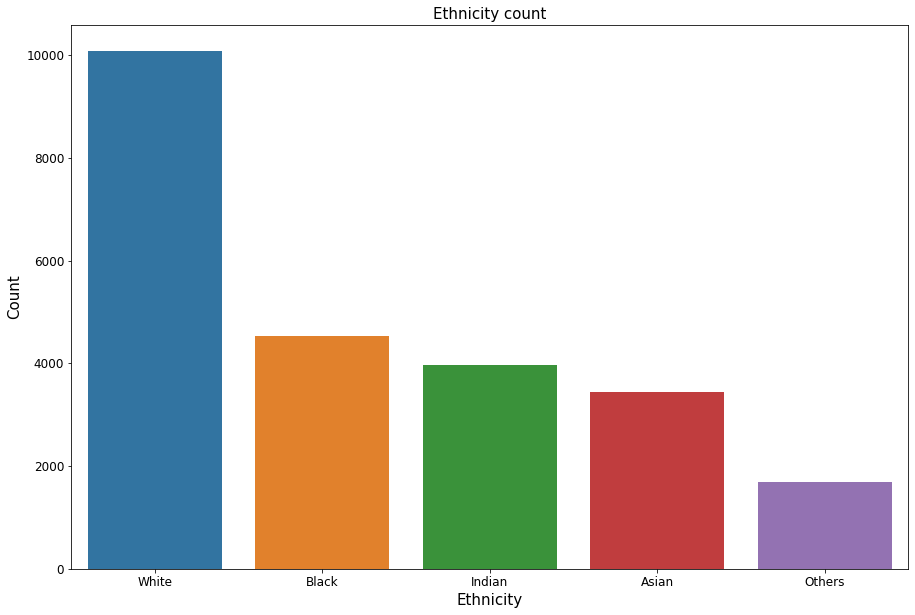

In [20]:
plt.figure(figsize=(15,10))
ax=sns.countplot(df['ethnicity_str'], order=df['ethnicity_str'].value_counts().index)
ax.set_title("Ethnicity count", size=15)
ax.set_xlabel("Ethnicity", size=15)
ax.set_ylabel("Count", size=15)
ax.tick_params(labelsize=12);

In [21]:
X.shape

(23705, 48, 48)

In [74]:
y_gender=np.array(df.gender)
y_gender.shape
y_ethnicity=np.array(df.ethnicity)
y_ethnicity.shape
y_age=np.array(df.age)
y_age.shape

(23705,)

### __Model Building__

#### __Gender Model__

In [23]:
import tensorflow as tf
import tensorflow.keras.layers as L

In [24]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

In [25]:
X=X.reshape(X.shape[0],48,48,1)

In [26]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_gender, test_size=0.25, random_state=37)

In [27]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  1


In [28]:
def build_model(num_classes, activation='softmax', loss='sparse_categorical_crossentropy', kernel_size=(3,3)):
    x = tf.keras.models.Sequential()
    inputs = tf.keras.Input(shape=(48, 48, 1))
    
    x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)
    x = tf.keras.layers.Conv2D(64, kernel_size=kernel_size, padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Conv2D(64, kernel_size=kernel_size, padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Conv2D(64, kernel_size=kernel_size, padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Conv2D(128, kernel_size=kernel_size, padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    outputs = tf.keras.layers.Dense(num_classes, activation=activation)(x)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    
    
    model.compile(
        optimizer='adam',
        loss=loss,
        metrics=['accuracy']
    )
    
    return model

In [29]:
gender_model = build_model(1, activation='sigmoid', loss='binary_crossentropy',kernel_size=(3,3))

In [30]:
gender_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 48, 48, 1)]       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 48, 48, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 48, 48, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 64)       

In [31]:
gender_history = gender_model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    batch_size=8,
    epochs=10,
    callbacks=[tf.keras.callbacks.ReduceLROnPlateau()],
    verbose=1
)

Epoch 1/10
2223/2223 [==============================] - 7s 3ms/step - loss: 0.4323 - accuracy: 0.7919 - val_loss: 0.3373 - val_accuracy: 0.8514
Epoch 2/10
2223/2223 [==============================] - 6s 3ms/step - loss: 0.3164 - accuracy: 0.8603 - val_loss: 0.2903 - val_accuracy: 0.8713
Epoch 3/10
2223/2223 [==============================] - 7s 3ms/step - loss: 0.2817 - accuracy: 0.8738 - val_loss: 0.3344 - val_accuracy: 0.8424
Epoch 4/10
2223/2223 [==============================] - 7s 3ms/step - loss: 0.2640 - accuracy: 0.8858 - val_loss: 0.2683 - val_accuracy: 0.8794
Epoch 5/10
2223/2223 [==============================] - 7s 3ms/step - loss: 0.2440 - accuracy: 0.8953 - val_loss: 0.2645 - val_accuracy: 0.8849
Epoch 6/10
2223/2223 [==============================] - 8s 3ms/step - loss: 0.2265 - accuracy: 0.9040 - val_loss: 0.2730 - val_accuracy: 0.8794
Epoch 7/10
2223/2223 [==============================] - 7s 3ms/step - loss: 0.2116 - accuracy: 0.9111 - val_loss: 0.3063 - val_accuracy:

In [32]:
#gender_history.history

In [33]:
score = gender_model.evaluate(X_test, y_test, verbose=0)

In [34]:
gender_model2 = build_model(2, activation='sigmoid', loss='sparse_categorical_crossentropy',kernel_size=(3,3))
gender_model2.fit(
  X_train,
    y_train,
    validation_data=(X_test, y_test),
    batch_size=8,
    epochs=10,
    callbacks=[tf.keras.callbacks.ReduceLROnPlateau()],
    verbose=1)

Epoch 1/10
2223/2223 [==============================] - 6s 3ms/step - loss: 0.4507 - accuracy: 0.7738 - val_loss: 0.3345 - val_accuracy: 0.8411
Epoch 2/10
2223/2223 [==============================] - 8s 4ms/step - loss: 0.3185 - accuracy: 0.8604 - val_loss: 0.3299 - val_accuracy: 0.8497
Epoch 3/10
2223/2223 [==============================] - 7s 3ms/step - loss: 0.2845 - accuracy: 0.8742 - val_loss: 0.3516 - val_accuracy: 0.8561
Epoch 4/10
2223/2223 [==============================] - 8s 4ms/step - loss: 0.2612 - accuracy: 0.8820 - val_loss: 0.3082 - val_accuracy: 0.8659
Epoch 5/10
2223/2223 [==============================] - 7s 3ms/step - loss: 0.2464 - accuracy: 0.8931 - val_loss: 0.2881 - val_accuracy: 0.8721
Epoch 6/10
2223/2223 [==============================] - 8s 3ms/step - loss: 0.2302 - accuracy: 0.9006 - val_loss: 0.2641 - val_accuracy: 0.8848
Epoch 7/10
2223/2223 [==============================] - 7s 3ms/step - loss: 0.2141 - accuracy: 0.9092 - val_loss: 0.2700 - val_accuracy:

In [35]:
X_train.shape

(17778, 48, 48, 1)

In [36]:
y_pred=gender_model.predict(X_test)

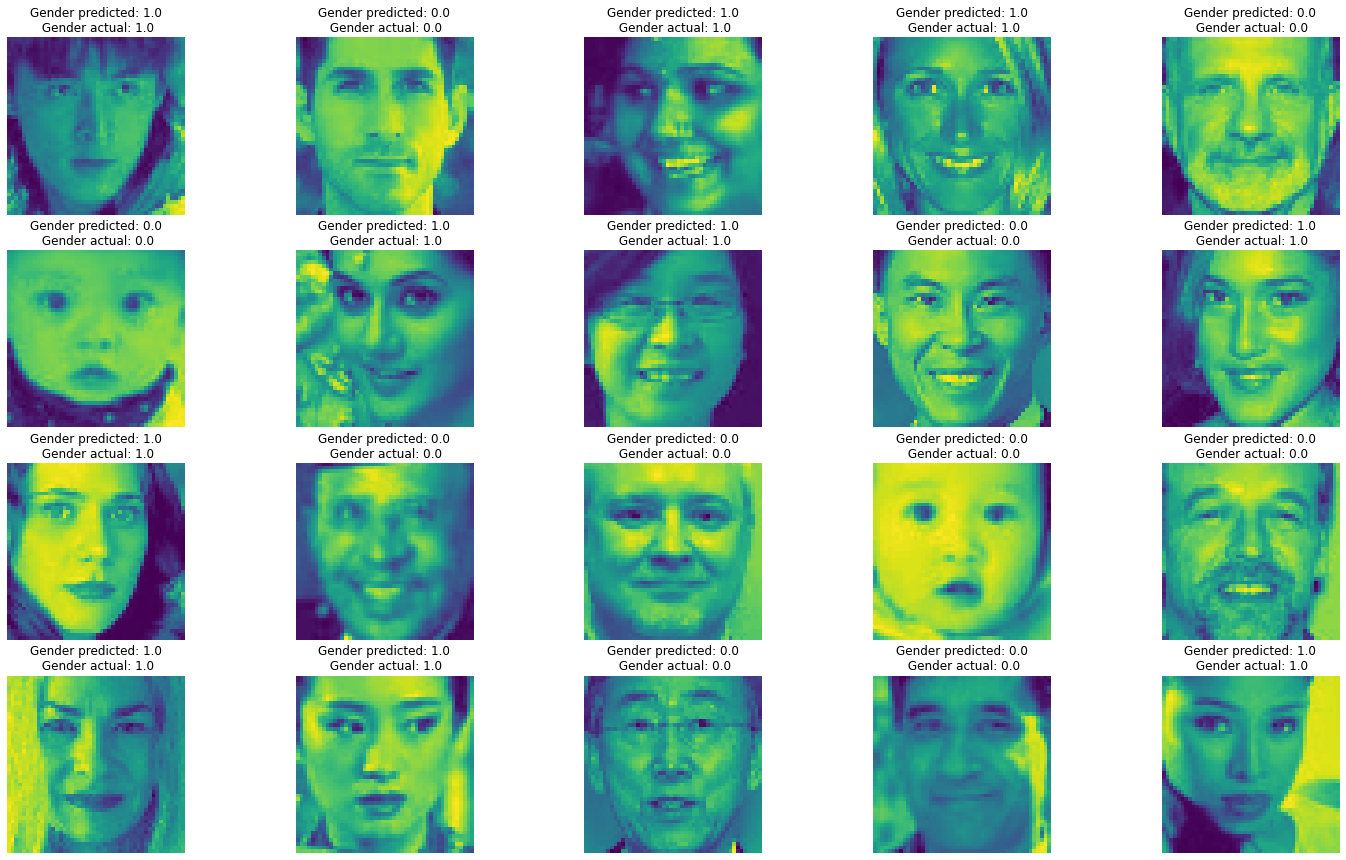

In [37]:
fig, axes = plt.subplots(4,5, figsize=(25,15))
# rand_number=np.random.randint(0, len(X), 20)
for ax in axes.flat:
    i=np.random.randint(0, len(y_test),1)
    X_plot=X_test[i].reshape(48,48)
    
    #print(X_plot.shape)
    ax.imshow(X_plot)
    ax.set_title( "Gender predicted: "+str(round(y_pred[i][0][0]))+ "\n Gender actual: "+str(round(y_pred[i][0][0] )))
    #ax.set_title( )
    ax.axis('off')
plt.show()

#### __Ethnicity Model__

In [75]:
X_ethnicity_train, X_ethnicity_test, y_ethnicity_train, y_ethnicity_test = train_test_split(
    X, y_ethnicity, test_size=0.20, random_state=37)

Have created a function for ethno model.

In [87]:
def build_ethno_model(num_classes, activation='softmax', loss='sparse_categorical_crossentropy', kernel_size=(3,3)):
    model = tf.keras.models.Sequential()
    #input_shape = (48,48,1)
    #conv 1
    model.add(tf.keras.layers.Conv2D(32, input_shape = (48,48,1), activation='relu', kernel_size=3, padding='same'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    # conv 2
    model.add(tf.keras.layers.Conv2D(64, activation='relu', kernel_size=3, padding='same'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    #conv 3
    model.add(tf.keras.layers.Conv2D(64, activation='relu', kernel_size=3, padding='same'))
    
    #conv 4
    model.add(tf.keras.layers.Conv2D(64, activation='relu', kernel_size=3, padding='same'))
    
    # conv 5
    model.add(tf.keras.layers.Conv2D(128, activation='relu', kernel_size=3, padding='same'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    
    model.add(tf.keras.layers.Flatten())
    
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(1024))
    model.add(tf.keras.layers.Activation('relu'))

    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(512))
    model.add(tf.keras.layers.Activation('relu'))
    

    
    model.add(tf.keras.layers.Dropout(0.5))   
    model.add(tf.keras.layers.Dense(num_classes))
    model.add(tf.keras.layers.Activation(activation))
    model.compile(loss=loss, metrics=['accuracy'],optimizer='rmsprop') # optimizer='rmsprop'
    return model

In [88]:
ethno_model = build_ethno_model(5,loss='sparse_categorical_crossentropy')

In [89]:
ethno_model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_67 (Conv2D)           (None, 48, 48, 32)        320       
_________________________________________________________________
max_pooling2d_47 (MaxPooling (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_68 (Conv2D)           (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_48 (MaxPooling (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_69 (Conv2D)           (None, 12, 12, 64)        36928     
_________________________________________________________________
conv2d_70 (Conv2D)           (None, 12, 12, 64)        36928     
_________________________________________________________________
conv2d_71 (Conv2D)           (None, 12, 12, 128)     

In [90]:
ethno=ethno_model.fit(X_ethnicity_train,y_ethnicity_train, verbose=1,     
                                       validation_data=(X_ethnicity_test, y_ethnicity_test),
    batch_size=32,
    epochs=20,
    callbacks=[tf.keras.callbacks.ReduceLROnPlateau()] )

Epoch 1/20
593/593 [==============================] - 4s 7ms/step - loss: 1.4342 - accuracy: 0.4973 - val_loss: 1.1915 - val_accuracy: 0.5446
Epoch 2/20
593/593 [==============================] - 4s 7ms/step - loss: 1.0351 - accuracy: 0.6366 - val_loss: 0.9495 - val_accuracy: 0.6815
Epoch 3/20
593/593 [==============================] - 4s 7ms/step - loss: 1.0028 - accuracy: 0.6505 - val_loss: 1.1114 - val_accuracy: 0.6389
Epoch 4/20
593/593 [==============================] - 4s 7ms/step - loss: 0.9910 - accuracy: 0.6589 - val_loss: 1.0766 - val_accuracy: 0.6395
Epoch 5/20
593/593 [==============================] - 4s 7ms/step - loss: 0.9775 - accuracy: 0.6618 - val_loss: 0.9388 - val_accuracy: 0.6714
Epoch 6/20
593/593 [==============================] - 4s 7ms/step - loss: 0.9772 - accuracy: 0.6649 - val_loss: 1.1232 - val_accuracy: 0.5914
Epoch 7/20
593/593 [==============================] - 4s 7ms/step - loss: 0.9938 - accuracy: 0.6558 - val_loss: 0.8623 - val_accuracy: 0.6931
Epoch 

In [46]:
ethno_model_small=build_model(5)

In [47]:
ethno_2=ethno_model_small.fit(X_ethnicity_train,y_ethnicity_train, verbose=1,     
                                       validation_data=(X_ethnicity_test, y_ethnicity_test),
    batch_size=8,
    epochs=20,
    callbacks=[tf.keras.callbacks.ReduceLROnPlateau()] )

Epoch 1/20
2371/2371 [==============================] - 7s 3ms/step - loss: 1.1584 - accuracy: 0.5554 - val_loss: 0.8628 - val_accuracy: 0.6864
Epoch 2/20
2371/2371 [==============================] - 7s 3ms/step - loss: 0.8587 - accuracy: 0.6874 - val_loss: 0.8019 - val_accuracy: 0.7193
Epoch 3/20
2371/2371 [==============================] - 7s 3ms/step - loss: 0.7746 - accuracy: 0.7236 - val_loss: 0.7613 - val_accuracy: 0.7353
Epoch 4/20
2371/2371 [==============================] - 7s 3ms/step - loss: 0.7217 - accuracy: 0.7461 - val_loss: 0.7483 - val_accuracy: 0.7387
Epoch 5/20
2371/2371 [==============================] - 7s 3ms/step - loss: 0.6711 - accuracy: 0.7640 - val_loss: 0.7350 - val_accuracy: 0.7427
Epoch 6/20
2371/2371 [==============================] - 7s 3ms/step - loss: 0.6262 - accuracy: 0.7752 - val_loss: 0.7141 - val_accuracy: 0.7562
Epoch 7/20
2371/2371 [==============================] - 8s 3ms/step - loss: 0.5857 - accuracy: 0.7935 - val_loss: 0.7386 - val_accuracy:

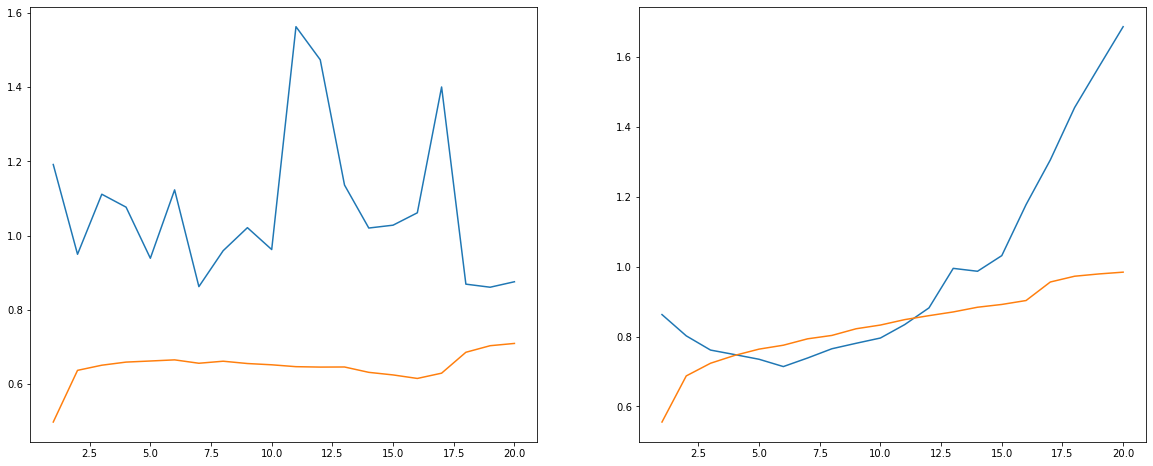

In [108]:
fig, ax = plt.subplots(1,2, figsize=(20,8))
ethno.history
l=np.arange(1,len(ethno.history['val_loss'])+1)
ax[0].plot(l, ethno.history['val_loss'])
ax[0].plot(l, ethno.history['accuracy'])
l1=np.arange(1,len(ethno_2.history['val_loss'])+1)
ax[1].plot(l1, ethno_2.history['val_loss'])
ax[1].plot(l1, ethno_2.history['accuracy']);
